# A/A Test

 **Цель:**
    
    убедиться в том, что наша система сплитования работает корректно, 
    и ключевая метрика не отличается между группами не только в конкретно нашем А/А-тесте, 
    но и в целом.

In [1]:
import pandas as pd
import pandahouse as ph
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind

connection = {'host': '***',
                      'database':'***',
                      'user':'***', 
                      'password':'***'
                     }

## 1. Выбрать данные по датам проведения A/A теста

In [2]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') AS likes,
    sum(action = 'view') AS views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-05-24' AND '2023-05-30'
    AND exp_group IN (2,3)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

df.exp_group.value_counts()

exp_group
3    8569
2    8480
Name: count, dtype: int64

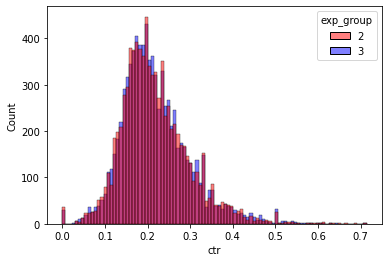

In [38]:
#sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group',
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Два распределения кажутся одинаковыми с незначительными различиями, которые кажутся рандомным отклонением.

## 2. Симуляция 10000 A/A тестов

1. ПсевдоГипотеза
   *   Нулевая гипотеза **Hₒ: mean2  = mean3** .
   *   Альтернативная гипотеза **Hₐ: mean2 ≠ mean3**
2. Тест - Welch's t-test (equal_var = False)
3. alternative='two-sided' (by default)
4. alpha = 0.05

In [50]:
alpha = 0.05
p_values = []
for _ in range(10000):
    group2 = df[df.exp_group == 2].ctr.sample(500, replace=False).to_list()
    group3 = df[df.exp_group == 3].ctr.sample(500, replace=False).to_list()
    p_value = ttest_ind(group2,
                group3,
                equal_var=False)[1]
    p_values.append(p_value)

In [51]:
p_values[:10]

[0.215976380068044,
 0.23549044894216897,
 0.9841762779392511,
 0.7043795840824754,
 0.502650945091506,
 0.5333311695427958,
 0.5698187167607339,
 0.3821486575420828,
 0.9581258367243358,
 0.10760792554136903]

## 3. Анализ полученных p-values

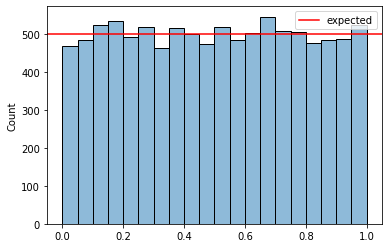

In [53]:
sns.histplot(data = p_values, 
              alpha=0.5,
              kde=False,
              bins=20)
plt.axhline(y=10000*alpha, color='red', label='expected')
plt.legend()

### Гистограмма

* Гистограмма для хорошего А/А теста должна быть примерно такой, какой она и получилась выше. 
* Вероятность определенного значения p-value должна быть примерно равна этому значению.


In [54]:
# <= 0.05 (alpha)

null_rejected_percent = (np.sum(np.array(p_values) <= alpha)/len(p_values) )* 100
print(f'Из 10000 тестов {round(null_rejected_percent/100*10000)} ({null_rejected_percent}%) позволят отклонить нулевую гипотезу и посчитать разницу между группами статистически значимой.')

Из 10000 тестов 468 (4.68%) позволят отклонить нулевую гипотезу и посчитать разницу между группами статистически значимой.


## Интерпретация

1. Мы знаем, что обе группы - равны, что нулевая гипотеза верна. И большинство А/А тестов не позволяют отклонить нулевую гипотезу.
2. Однако чуть меньше 5% все-таки ложно видят статистическую разницу там, где ее на самом деле нет.
3. Но именно это число мы и заложили в нашу ошибку первого рода (alpha = 0.05). 
4. Так что можно считать, что статистически значимые различия между двумя группами встречаются только в результате случайного ложного срабатывания и наша система сплитования работает корректно.